In [15]:
import torch
import itertools

def generate_skew_symmetric_matrix(p, seed=0):
    torch.manual_seed(seed)
    A = torch.randn(p, p)
    return A - A.T  # Make it skew-symmetric

def is_PtAP_equal_to_At(A, P):
    Pt = P.T
    At = -A
    transformed = Pt @ A @ P
    # print(transformed - At)
    return torch.allclose(transformed, At, atol=1e-6)

def permutation_matrix(perm):
    p = len(perm)
    P = torch.zeros(p, p)
    for i, j in enumerate(perm):
        P[i, j] = 1
    return P

# Test in dimension p = 3
p = 6
A = generate_skew_symmetric_matrix(p)
perms = list(itertools.permutations(range(p)))


results = {}
for perm in perms:
    P = permutation_matrix(perm)
    results[perm] = is_PtAP_equal_to_At(A, P)

print("Skew-symmetric A:")
print("\nPermutations for which P^T A P == A^T:")
for perm, works in results.items():
    if works:
        print(perm)


Skew-symmetric A:

Permutations for which P^T A P == A^T:


In [3]:
import torch

def generate_skew_symmetric_matrix(p, seed=0):
    torch.manual_seed(seed)
    A = torch.randn(p, p)
    return A - A.T

def transposition_matrix(p, i, j):
    Q = torch.eye(p)
    Q[[i, j], :] = Q[[j, i], :]
    return Q

def extract_submatrix(M, indices):
    return M[indices][:, indices]

# Set dimension and indices to swap
p = 5
i, j = 1, 3  # example transposition indices

# Generate skew-symmetric matrix A and transposition Q
A = generate_skew_symmetric_matrix(p)
Q = transposition_matrix(p, i, j)

# Compute Q^T A Q
A_conjugated = Q.T @ A @ Q

print(A_conjugated + A)
# Extract the 2x2 submatrix on rows and cols {i, j}
submatrix = extract_submatrix(A_conjugated, [i, j])

submatrix + extract_submatrix(A, [i, j])


tensor([[ 0.0000, -2.1666, -3.3885, -2.1666,  0.4613],
        [ 2.1666,  0.0000, -1.9966,  0.0000,  2.6249],
        [ 3.3885,  1.9966,  0.0000,  1.9966,  1.3952],
        [ 2.1666,  0.0000, -1.9966,  0.0000,  2.6249],
        [-0.4613, -2.6249, -1.3952, -2.6249,  0.0000]])


tensor([[0., 0.],
        [0., 0.]])

In [ ]:
import torch

def compute_Gpp(g_prime, g_double_prime, A, Y):
    """
    Compute empirical estimate of G''(0) = E[(Ay)^T g''(y) Ay - g'(y)^T A^T A y]

    Args:
        g_prime: function (N x p) -> (N x p), computes gradient for each sample
        g_double_prime: function (N x p) -> (N x p x p), computes Hessian for each sample
        A: skew-symmetric matrix of shape (p x p)
        Y: data matrix of shape (N x p)

    Returns:
        Estimated G''(0) as a scalar
    """
    A = A.float()
    Y = Y.float()

    AY = Y @ A.T  # (N x p)
    H = g_double_prime(Y)  # (N x p x p)

    # First term: (Ay)^T H (Ay)
    AY_exp = AY.unsqueeze(2)  # (N x p x 1)
    term1 = torch.bmm(torch.bmm(AY.unsqueeze(1), H), AY_exp).squeeze()  # (N,)

    # Second term: g'(y)^T A^T A y
    A2 = A.T @ A
    A2Y = Y @ A2.T
    gY = g_prime(Y)
    term2 = (gY * A2Y).sum(dim=1)  # (N,)
    print(term1.mean().item(), term2.mean().item())
    return (term1 - term2).mean().item()


## SANITY CHECK
# def compute_Gpp_loop(g_prime, g_double_prime, A, Y):
#     """
#     Loop-based version to compute empirical estimate of G''(0) for clarity.
#     Computes G''(0) = E[(Ay)^T g''(y) Ay - g'(y)^T A^T A y] sample by sample.

#     Args:
#         g_prime: function (1 x p) -> (1 x p), gradient function
#         g_double_prime: function (1 x p) -> (1 x p x p), Hessian function
#         A: skew-symmetric matrix of shape (p x p)
#         Y: data matrix of shape (N x p)

#     Returns:
#         Scalar estimate of G''(0)
#     """
#     A = A.float()
#     Y = Y.float()
#     A2 = A.T @ A

#     N = Y.shape[0]
#     total_term1 = 0.0
#     total_term2 = 0.0

#     for i in range(N):
#         y = Y[i].unsqueeze(0)  # (1 x p)
#         Ay = (y @ A.T).squeeze(0)  # (p,)
#         H = g_double_prime(y).squeeze(0)  # (p x p)
#         grad = g_prime(y).squeeze(0)  # (p,)

#         term1 = Ay @ H @ Ay  # scalar
#         term2 = grad @ A2 @ y.squeeze(0)  # scalar

#         total_term1 += term1.item()
#         total_term2 += term2.item()

#     print("Average (Ay)^T H (Ay):", total_term1 / N)
#     print("Average g'(y)^T A^T A y:", total_term2 / N)
#     return (total_term1 - total_term2) / N


In [405]:
from torch.distributions import Dirichlet, Normal

import torch
from torch.distributions.normal import Normal

def mollified_relu_grad(Y, sigma=0.02):
    """
    Compute gradient of mollified ReLU loss w.r.t. Y.
    Y: (N x p), sigma: scalar
    Returns: (N x p) gradient matrix
    """
    normal = Normal(0, 1)
    N, p = Y.shape

    # Negative term gradient
    x = -Y
    grad_neg = normal.cdf(x / sigma)

    # Sum constraint term
    w = Y.sum(dim=1, keepdim=True) - 1  # shape: (N x 1)
    grad_sum = normal.cdf(w / (sigma * p**0.5))  # shape: (N x 1)
    grad_sum_expanded = grad_sum.expand(-1, p)

    return grad_neg + grad_sum_expanded


def mollified_relu_hess(Y, sigma=0.02):
    """
    Compute Hessian of mollified ReLU loss w.r.t. Y.
    Returns (N x p x p) Hessians per sample.
    """
    normal = Normal(0, 1)
    N, p = Y.shape

    # Negative term Hessian (diagonal)
    x = -Y
    diag_vals = normal.log_prob(x / sigma).exp() / sigma  # shape: (N x p)
    H_neg = torch.diag_embed(diag_vals)  # (N x p x p)

    # Sum constraint Hessian (rank-1 update)
    w = Y.sum(dim=1, keepdim=True) - 1  # (N x 1)
    phi_vals = normal.log_prob(w / (sigma * p**0.5)).exp() / (sigma * p**0.5)  # (N x 1)
    ones = torch.ones((N, p, 1), device=Y.device)
    H_sum = phi_vals.view(-1, 1, 1) * torch.bmm(ones, ones.transpose(1, 2))  # (N x p x p)

    return H_neg + H_sum



In [341]:
alpha = torch.tensor([[10, 1, 1], [1, 10, 1]], dtype= torch.float64)
# alpha = torch.tensor([[5, 1]], dtype= torch.float64)
n= 200
K, p = alpha.shape
sigma = 1
# torch.manual_seed(5)
normal, dir = Normal(0, sigma), Dirichlet(alpha)

X = dir.sample((n // K,)).transpose(0, 1).reshape(n, p)[:, :2]
epsilon = normal.sample((n,p-1))
A = torch.tensor([[0.0, -1.0], [1.0, 0.0]])

# Compute
Gpp_val = compute_Gpp(mollified_relu_grad, mollified_relu_hess, A, epsilon)

print("Estimated G''(0):", Gpp_val)

0.8180803656578064 -0.4734242558479309
Estimated G''(0): 1.2915046215057373


In [ ]:
sigmas = torch.arange(0.01, 5.01, 0.01, dtype=torch.float64)
gpp_values = []
X = dir.sample((n // K,)).transpose(0, 1).reshape(n, p)[:, :2]

for sigma_val in sigmas:
    normal = Normal(0, sigma_val)
    epsilon = normal.sample((n, p - 1))
    X_noisy = X + epsilon

    Gpp_val = compute_Gpp(
        lambda Y: mollified_relu_grad(Y, sigma=sigma_val),
        lambda Y: mollified_relu_hess(Y, sigma=sigma_val),
        A,
        X_noisy
    )
    gpp_values.append(Gpp_val)



Processed sigma = 0.50, G''(0) = 0.4928
Processed sigma = 1.00, G''(0) = 0.6409
Processed sigma = 1.50, G''(0) = 1.0685
Processed sigma = 2.00, G''(0) = 1.5515
Processed sigma = 2.50, G''(0) = 2.0826
Processed sigma = 3.00, G''(0) = 2.6065
Processed sigma = 3.50, G''(0) = 3.1868
Processed sigma = 4.00, G''(0) = 3.7251
Processed sigma = 4.50, G''(0) = 4.2719
Processed sigma = 5.00, G''(0) = 4.8344


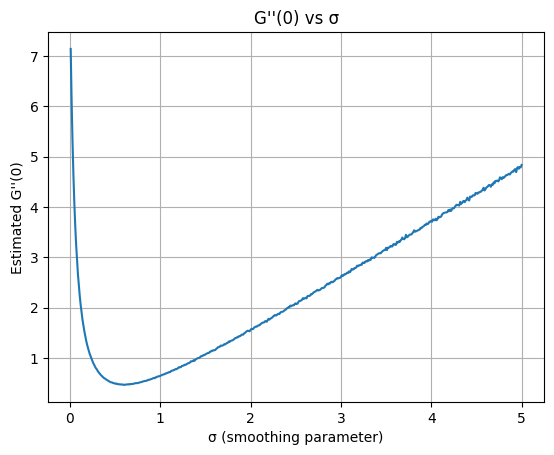

In [141]:
import matplotlib.pyplot as plt

plt.plot(sigmas.numpy(), gpp_values)
plt.xlabel("σ (smoothing parameter)")
plt.ylabel("Estimated G''(0)")
plt.title("G''(0) vs σ")
plt.grid(True)
plt.show()

In [543]:
import torch
from torch.distributions import Dirichlet, Normal
def compute_cross_Gpp(g_double_prime, A1, A2, Y):
    """
    Compute empirical estimate of G_cross''(0) = E[y^T A1^T g''(y) A2 y]

    Args:
        g_double_prime: function (N x p) -> (N x p x p), computes Hessian per sample
        A1: first skew-symmetric matrix (p x p)
        A2: second skew-symmetric matrix (p x p)
        Y: data matrix of shape (N x p)

    Returns:
        Estimated cross term G''(0) = E[y^T A1^T g''(y) A2 y]
    """
    A1 = A1.float()
    A2 = A2.float()
    Y = Y.float()

    AY = Y @ A2.T           # (N x p)
    H = g_double_prime(Y)   # (N x p x p)

    # First term: (A2 y)^T H (A1 y)
    AY_exp = AY.unsqueeze(2)                 # (N x p x 1)
    A1Y = (Y @ A1.T).unsqueeze(1)            # (N x 1 x p)
    term = torch.bmm(A1Y, torch.bmm(H, AY_exp)).squeeze()  # (N,)

    return term.mean().item()


# Define 4D Dirichlet distribution
alpha_4d = torch.tensor([[10.0, 1.0, 1.0, 1.0],
                         [1.0, 10.0, 1.0, 1.0],
                         [1.0, 1.0, 10.0, 1.0],
                         [1.0, 1.0, 1.0, 10.0]], dtype=torch.float64)
dir_4d = Dirichlet(alpha_4d)

# Sampling parameters
n = 200000
K, p = alpha_4d.shape
sigma = 0.02
normal = Normal(0, sigma)

# Sample data
X = dir_4d.sample((n // K,)).transpose(0, 1).reshape(n, p)
epsilon = normal.sample((n, p))
Y = X + epsilon

# Construct two skew-symmetric basis matrices with disjoint support
def skew_basis(p, i, j):
    B = torch.zeros((p, p), dtype=torch.float64)
    B[i, j] = 1.0
    B[j, i] = -1.0
    return B



In [547]:
import numpy as np

def construct_M(p, Y, compute_cross_Gpp, mollified_relu_hess):
    q = (p * (p - 1)) // 2
    M = np.zeros((q, q))
    
    # Map basis index to (i, j)
    index_to_pair = []
    for i in range(p):
        for j in range(i + 1, p):
            index_to_pair.append((i, j))
    
    for a in range(q):
        i, j = index_to_pair[a]
        for b in range(a, q):  # Only need upper triangle due to symmetry
            k, l = index_to_pair[b]
            
            val = compute_cross_Gpp(
                mollified_relu_hess,
                skew_basis(p, i, j),
                skew_basis(p, k, l),
                Y
            )
            M[a, b] = val
            M[b, a] = val  # Symmetry

    return M

In [581]:
import torch
from torch.distributions import Dirichlet, Normal

# Use existing gradient and Hessian functions
def compute_lambda_expectation_term(g_prime, g_double_prime, Y):
    """
    Estimate E[lambda * y_i^2 - g'_i(y) * y_i] using the average eigenvalue of the Hessian.

    Args:
        g_prime: function (N x p) -> (N x p), gradient of loss
        g_double_prime: function (N x p) -> (N x p x p), Hessian of loss
        Y: data matrix (N x p)

    Returns:
        Scalar estimate of E[lambda * y_i^2 - g'_i(y) * y_i]
    """
    N, p = Y.shape
    grad = g_prime(Y)  # (N x p)
    hess = g_double_prime(Y)  # (N x p x p)

    # Mean eigenvalue per sample instead of min
    min_lambdas = torch.linalg.eigvalsh(hess).min(dim=-1).values  # (N,)
    lambda_mean = min_lambdas.mean()  # Scalar
    print(lambda_mean)

    # Pick i = 0 (exchangeability)
    y_i = Y[:, 0]
    grad_i = grad[:, 0]
    lambda_term = lambda_mean * y_i ** 2
    grad_term = grad_i * y_i

    expectation = (lambda_term - grad_term).mean().item()
    return expectation

# Sample Y ~ z + epsilon, with z ~ Dirichlet, epsilon ~ N(0, sigma^2)
def sample_exchangeable_data(n=6000, alpha=None, sigma=0.1, seed=42):
    if alpha is None:
        alpha = torch.tensor([[10.0, 1.0, 1.0], [1.0, 10.0, 1.0], [1.0, 1.0, 10.0]], dtype=torch.float64)
    torch.manual_seed(seed)
    K, p = alpha.shape
    dirichlet = Dirichlet(alpha)
    normal = Normal(0, sigma)

    # Sample z from Dirichlet
    Z = dirichlet.sample((n // K,)).transpose(0, 1).reshape(n, p)

    # Sample epsilon
    epsilon = normal.sample((n, p))

    return Z + epsilon

# Run the experiment
Y = sample_exchangeable_data(n=3000, sigma=0.1)
estimate = compute_lambda_expectation_term(mollified_relu_grad, mollified_relu_hess, Y)
estimate


tensor(0.0445, dtype=torch.float64)


-0.1652799034235356